In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# قراءة البيانات
df = pd.read_csv('train_u6lujuX_CVtuZ9i (1).csv')

# 1️⃣ حذف العمود غير المهم
df.drop('Loan_ID', axis=1, inplace=True)

# 2️⃣ معالجة القيم الفارغة
# الأعمدة الفئوية → نملأ بالقيمة الأكثر تكرارًا (mode)
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents', 'Loan_Status']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# الأعمدة العددية → نملأ بالوسيط (median)
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# 3️⃣ إنشاء ميزة جديدة: TotalIncome
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# 4️⃣ تحويل الأعمدة الفئوية إلى أرقام
le = LabelEncoder()
for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents', 'Loan_Status']:
    df[col] = le.fit_transform(df[col])

# 5️⃣ Feature Scaling (مهم للنماذج مثل Logistic Regression)
scaler = StandardScaler()
scaled_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# 6️⃣ تقسيم البيانات إلى تدريب واختبار
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Data preprocessing completed successfully!")
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Data preprocessing completed successfully!
Training set shape: (429, 12), Test set shape: (185, 12)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# تحديد أنواع العقوبات
penalties = ['l1', 'l2']

# تدريب وتقييم كل نموذج
for penalty in penalties:
    # ملاحظة: solver='liblinear' يدعم L1 و L2
    model = LogisticRegression(penalty=penalty, solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    
    # التنبؤ على مجموعة الاختبار
    y_pred = model.predict(X_test)
    
    # تقييم النموذج
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"--- Logistic Regression with {penalty.upper()} penalty ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")


--- Logistic Regression with L1 penalty ---
Accuracy : 0.7838
Precision: 0.7564
Recall   : 0.9833
F1 Score : 0.8551

--- Logistic Regression with L2 penalty ---
Accuracy : 0.7838
Precision: 0.7564
Recall   : 0.9833
F1 Score : 0.8551



In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# تعريف نموذج اللوجستيك
logreg = LogisticRegression(random_state=42, max_iter=1000)

# المعاملات المراد ضبطها
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],  # saga يدعم L1, L2, ElasticNet
    'l1_ratio': [0, 0.5, 1]  # فقط relevant إذا كانت elasticnet
}

# استخدام StratifiedKFold لضمان توازن الفئات
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# إعداد GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',   # يمكن تغييره إلى 'accuracy', 'precision', 'recall' حسب هدفك
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# تدريب GridSearchCV
grid_search.fit(X_train, y_train)

# أفضل معاملات
print("Best Parameters:", grid_search.best_params_)

# أفضل F1 Score على مجموعة التدريب (cross-validated)
print("Best F1 Score (CV):", grid_search.best_score_)

# التقييم على مجموعة الاختبار
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n--- Evaluation on Test Set ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga'}
Best F1 Score (CV): 0.8852880335855777

--- Evaluation on Test Set ---
Accuracy : 0.7838
Precision: 0.7564
Recall   : 0.9833
F1 Score : 0.8551


C:\Users\LEGION\.anaconda\anacoda 4\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



--- Decision Tree with criterion = gini ---
Accuracy : 0.7568
Precision: 0.7451
Recall   : 0.9500
F1 Score : 0.8352


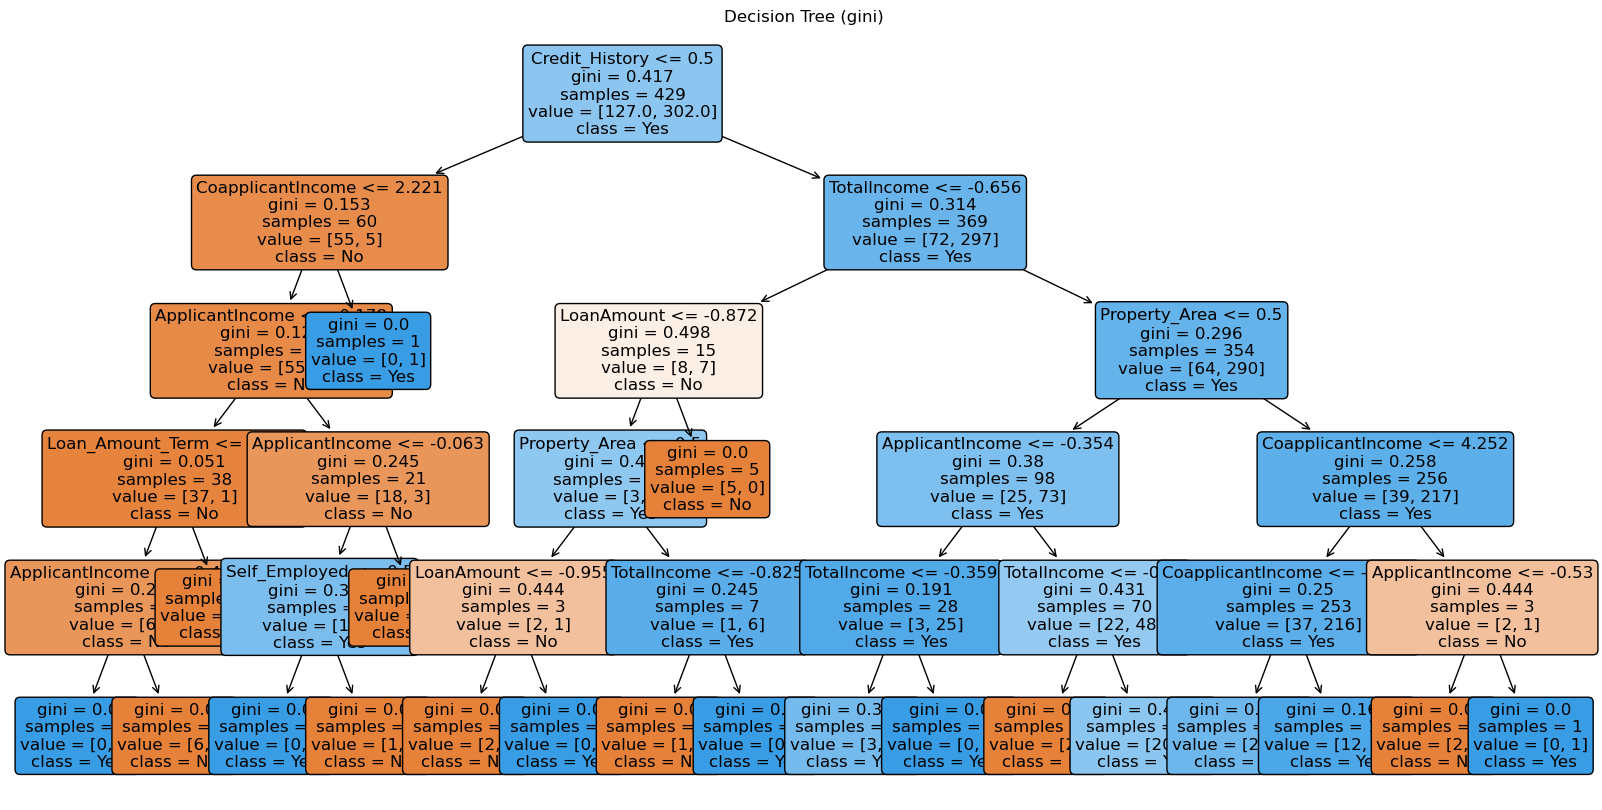


--- Decision Tree with criterion = entropy ---
Accuracy : 0.7676
Precision: 0.7516
Recall   : 0.9583
F1 Score : 0.8425


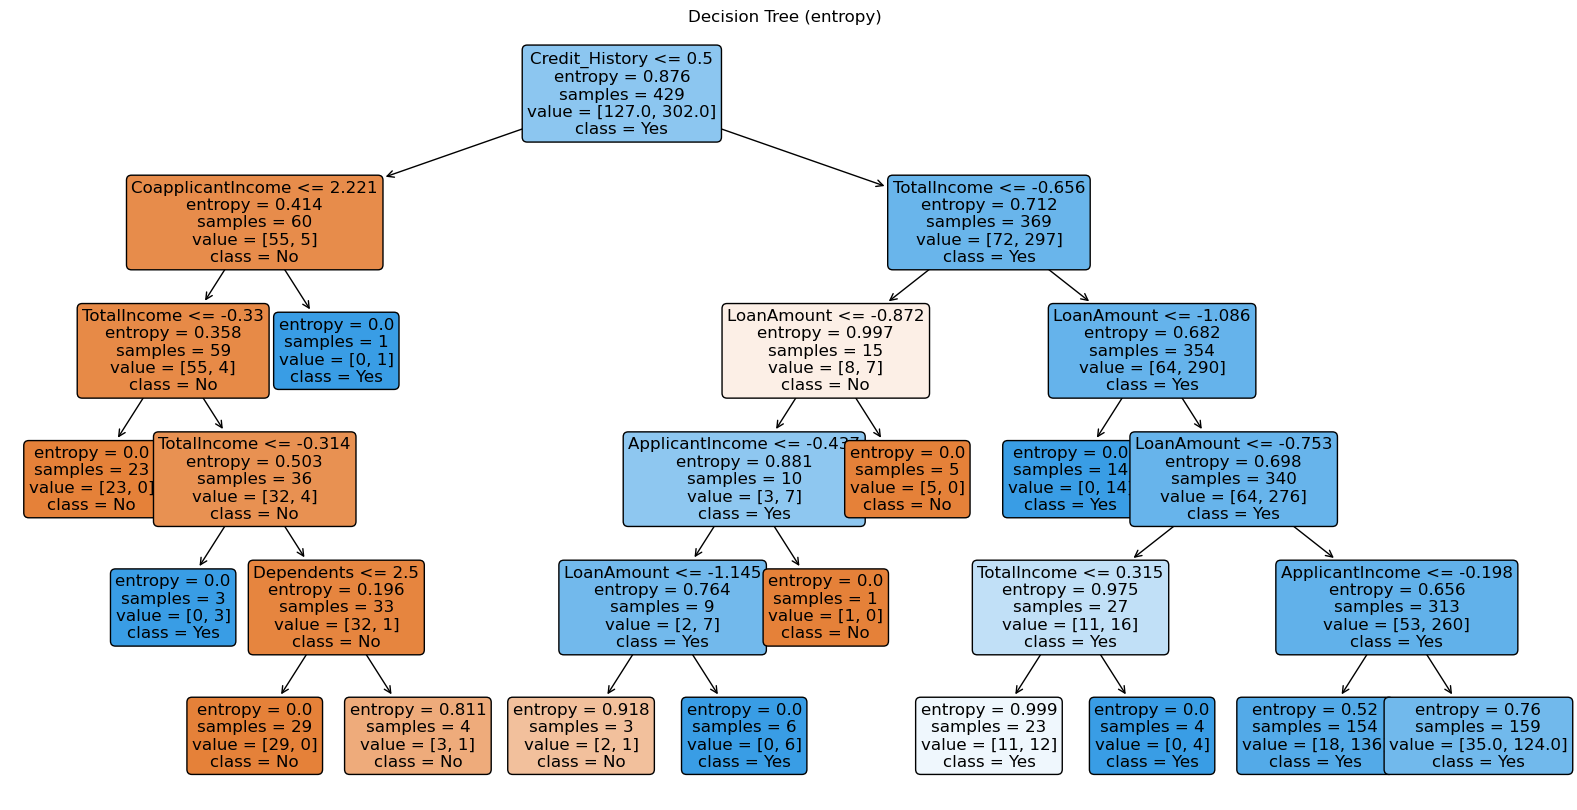

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# قائمة المعايير لتجربتها
criteria = ['gini', 'entropy']

# ضبط بعض المعاملات الأساسية
max_depth_options = [3, 5, 7, None]
min_samples_split_options = [2, 5, 10]
min_samples_leaf_options = [1, 2, 4]

# تدريب نموذج Decision Tree لكل criterion
for criterion in criteria:
    print(f"\n--- Decision Tree with criterion = {criterion} ---")
    dt = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=5,           # يمكنك تجربة القيم المختلفة
        min_samples_split=2,   # يمكنك تجربة القيم المختلفة
        min_samples_leaf=1,    # يمكنك تجربة القيم المختلفة
        random_state=42
    )
    
    # تدريب النموذج
    dt.fit(X_train, y_train)
    
    # التنبؤ على مجموعة الاختبار
    y_pred = dt.predict(X_test)
    
    # تقييم الأداء
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
    
    # رسم الشجرة
    plt.figure(figsize=(20,10))
    plot_tree(
        dt, 
        feature_names=X_train.columns, 
        class_names=['No', 'Yes'], 
        filled=True, 
        rounded=True,
        fontsize=12
    )
    plt.title(f"Decision Tree ({criterion})")
    plt.show()


Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1 Score (CV): 0.8892155662494231

--- Test Set Performance ---
              precision    recall  f1-score   support

          No       0.84      0.42      0.56        65
         Yes       0.75      0.96      0.84       120

    accuracy                           0.77       185
   macro avg       0.80      0.69      0.70       185
weighted avg       0.78      0.77      0.74       185



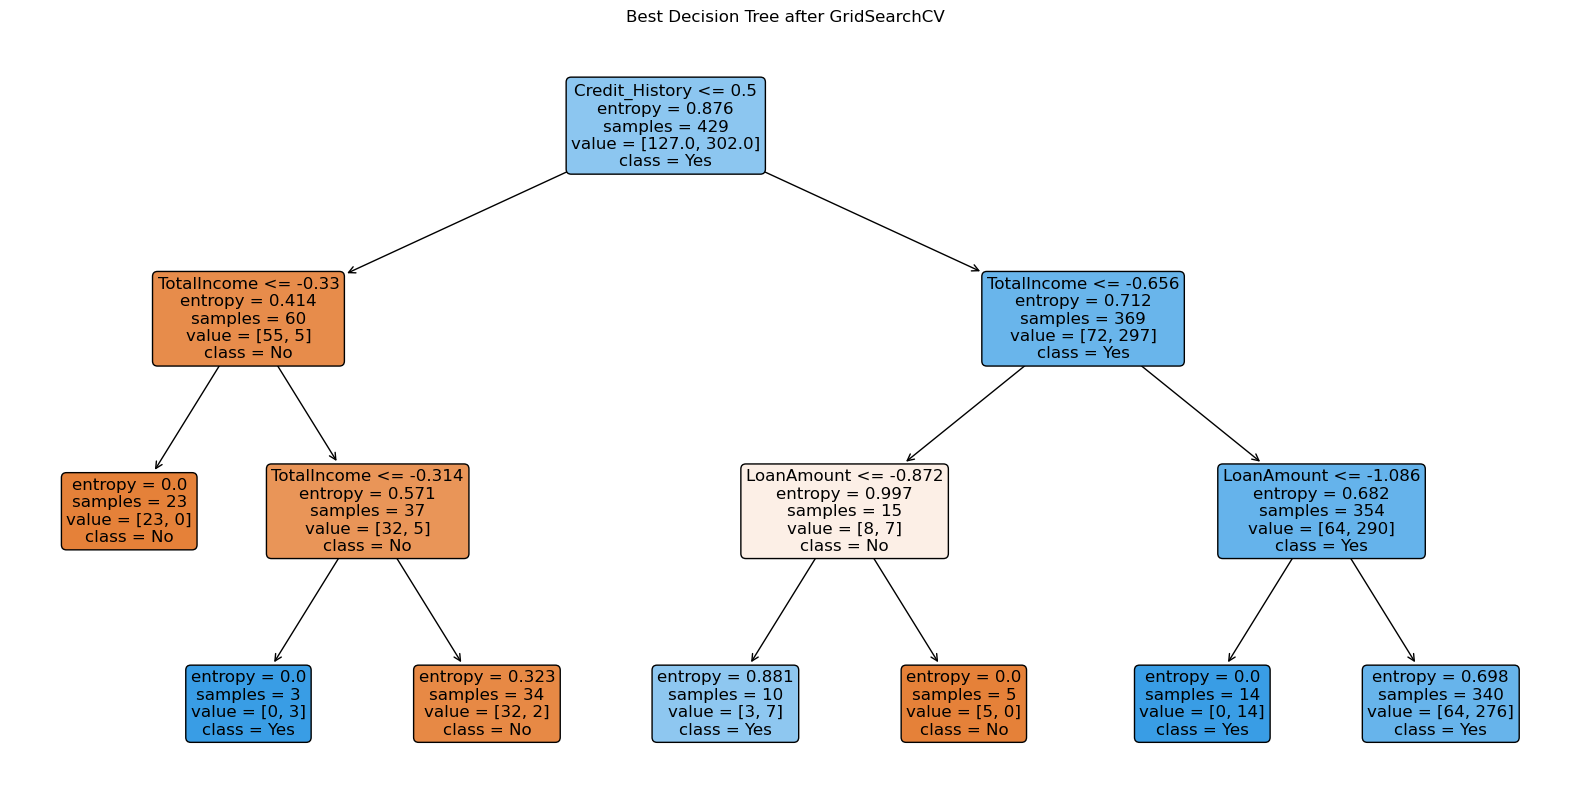

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# إعداد Decision Tree الأساسي
dt = DecisionTreeClassifier(random_state=42)

# شبكة المعاملات (Hyperparameter Grid)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# إعداد GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='f1',        # يمكن تغييره إلى 'accuracy', 'precision', إلخ
    n_jobs=-1
)

# تدريب GridSearchCV
grid_search.fit(X_train, y_train)

# أفضل المعاملات
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# تقييم النموذج الأفضل على مجموعة الاختبار
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

print("\n--- Test Set Performance ---")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

# رسم الشجرة الأفضل
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    best_dt, 
    feature_names=X_train.columns, 
    class_names=['No', 'Yes'], 
    filled=True, 
    rounded=True,
    fontsize=12
)
plt.title("Best Decision Tree after GridSearchCV")
plt.show()
